In [ ]:
import torch
import torch.nn as nn

import pandas as pd
import os
import json

In [ ]:
from tempdisagg import TempDisaggModel
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as ts 

In [ ]:
data = pd.read_csv('Data/Macro.csv')
data

,Unnamed: 0,Year,Month,Unnamed: 3,Inflation,Population,GDP,Imports,Exports,Agriculture,Industry,Services,USDPHP,Nominal GDP
0,Jan-86,1986,January,1/1/1986,3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0417,NaN
1,Feb-86,1986,February,1/2/1986,4.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.4609,NaN
2,Mar-86,1986,March,1/3/1986,4.2,NaN,1016182.62,NaN,NaN,19.77,33.19,47.03,20.7811,162291.0
3,Apr-86,1986,April,1/4/1986,2.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5045,NaN
4,May-86,1986,May,1/5/1986,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5003,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,25-Aug,2025,August,1/8/2025,1.5,NaN,NaN,11112.23,7126.04,NaN,NaN,NaN,NaN,NaN
476,25-Sep,2025,September,1/9/2025,1.7,NaN,5316054.33,11944.28,7274.67,7.43,25.87,66.70,NaN,6557979.0
477,25-Oct,2025,October,1/10/2025,1.7,NaN,NaN,11641.73,7448.17,NaN,NaN,NaN,NaN,NaN
478,25-Nov,2025,November,1/11/2025,1.5,NaN,NaN,10421.98,6908.34,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = pd.DataFrame({'Index': data['Year']})
df['Index'] = df['Index'].astype(int) * 10 + ((df.index // 3) % 4 + 1)
df['Grain'] = (list(range(1, 4)) * len(df))[:len(df)]

In [ ]:
df['y'] = data['Nominal GDP']
df['y'] = df.groupby('Index')['y'].bfill()
#df['X'] = 1.0
df['X'] = (
    pd.to_numeric(data['Exports'], errors='coerce') +
    pd.to_numeric(data['Imports'], errors='coerce')
) * pd.to_numeric(data['USDPHP'], errors='coerce')
df = df[(df['Index'] // 10).between(1991, 2024)]
df = df.reset_index(drop=True)

In [ ]:
df

,Index,Grain,y,X
0,19911,1,325283.0,4.440744e+04
1,19911,2,325283.0,4.920888e+04
2,19911,3,325283.0,5.093200e+04
3,19912,1,341433.0,4.485546e+04
4,19912,2,341433.0,4.650324e+04
...,...,...,...,...
403,20243,2,6254621.0,1.023885e+06
404,20243,3,6254621.0,9.880884e+05
405,20244,1,7577838.0,1.042692e+06
406,20244,2,7577838.0,9.585044e+05


In [ ]:
data['Exports_numeric'] = pd.to_numeric(data['Exports'], errors='coerce')
data['Imports_numeric'] = pd.to_numeric(data['Imports'], errors='coerce')
data['USDPHP_numeric'] = pd.to_numeric(data['USDPHP'], errors='coerce')

data['Monthly_Trade_PHP'] = (
    data['Exports_numeric'] + data['Imports_numeric']
) * data['USDPHP_numeric']

# Create quarterly trade by summing 3 months
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + 
                             data['Month'].astype(str) + '-01')
data.set_index('Date', inplace=True)

# Resample to quarterly sum
quarterly_trade = data['Monthly_Trade_PHP'].resample('QE').sum()

# Get quarterly GDP (remove NaNs)
quarterly_gdp = data['Nominal GDP'].resample('QE').mean().dropna()

# Align both series on common dates
common_dates = quarterly_gdp.index.intersection(quarterly_trade.index)
gdp_series = quarterly_gdp.loc[common_dates]
trade_series = quarterly_trade.loc[common_dates]

print(f"Aligned series length: {len(gdp_series)} quarters")
print(f"GDP mean: {gdp_series.mean():,.0f}")
print(f"Trade mean: {trade_series.mean():,.0f}")
print(f"Trade/GDP ratio: {trade_series.mean()/gdp_series.mean():.2%}")

Aligned series length: 159 quarters
GDP mean: 2,219,008
Trade mean: 1,078,717
Trade/GDP ratio: 48.61%


In [ ]:
from statsmodels.tsa.stattools import coint
# Test for cointegration
coint(gdp_series, trade_series, autolag='AIC')

(np.float64(0.31171419238856),
 np.float64(0.9910216440880458),
 array([-3.96709884, -3.37507483, -3.07140199]))

In [ ]:
model = TempDisaggModel(method="litterman-opt", conversion="sum")
model.fit(df)


Temporal Disaggregation Model Summary

Method: litterman-opt
Estimated rho: 0.9900
      Coef.    Std.Err.            t-stat       P>|t| Signif.       Score
0.445547971 0.000000099 4486481.191089949 0.000000000     *** 0.000000172


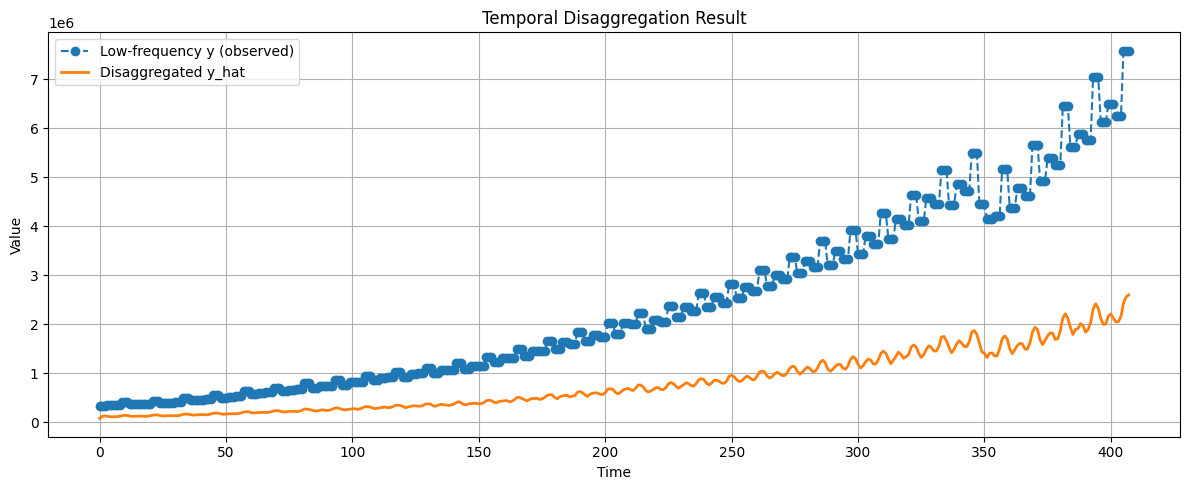

In [ ]:
y_hat = model.predict(full=False)

# Optional: post-estimation adjustment
y_adj = model.adjust_output(full=False)

# Summary and plot
model.summary()
model.plot()

In [ ]:
df['predicted']=y_hat
data['NominalGDP_disagg']=y_hat

,Index,Grain,y,X,predicted
0,19911,1,325283.0,4.440744e+04,7.833143e+04
1,19911,2,325283.0,4.920888e+04,1.164168e+05
2,19911,3,325283.0,5.093200e+04,1.305347e+05
3,19912,1,341433.0,4.485546e+04,1.185828e+05
4,19912,2,341433.0,4.650324e+04,1.129593e+05
...,...,...,...,...,...
403,20243,2,6254621.0,1.023885e+06,2.050000e+06
404,20243,3,6254621.0,9.880884e+05,2.158310e+06
405,20244,1,7577838.0,1.042692e+06,2.430754e+06
406,20244,2,7577838.0,9.585044e+05,2.551328e+06
